In [280]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
sns.set_style("dark")
sns.set_context("talk")
sns.set(rc = {'figure.figsize':(20,10)}, font_scale=1.5)

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_datareader.data import DataReader
import datetime as dt

# libraries for pipeline|
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA

# Gridsearch
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

#metrics
import sklearn.metrics as metrics

# Models to try
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

# custom functions
from modules import functions

# Market Data Gathering

In [281]:
# Important dates
start = dt.datetime(2022,7,23)
end = dt.datetime(2022,8,14)


In [282]:
# import data
nflx = DataReader("NFLX",  "yahoo", start, end)
gspc = DataReader("^GSPC", "yahoo", start, end)

# sentiment data
tweet_sentiment = pd.read_csv('../data/tweets/classified/tweets_mean_sentiment.csv', index_col=0)
news_sentiment = pd.read_csv('../data/news/classified/news_mean_sentiment.csv', index_col=0)

# turn dates to datetime
tweet_sentiment.index = pd.to_datetime(tweet_sentiment.index)
news_sentiment.index = pd.to_datetime(news_sentiment.index)

# remove weekends, for now
tweet_sentiment = tweet_sentiment[tweet_sentiment.index.dayofweek < 5]
news_sentiment = news_sentiment[news_sentiment.index.dayofweek < 5]

# # cut data from sentiment to start and end dates
tweet_sentiment = tweet_sentiment[start:end]
news_sentiment = news_sentiment[start:end]

In [283]:
# concatenate stock and market data
features = functions.concatRename(nflx, 'nflx_', gspc, 'gspc_')

# add sentiment features
merged_features = pd.concat([features, news_sentiment['news_daily_sentiment'], tweet_sentiment['tweet_sentiment_pred']], join='outer', axis=1)

# Set-up time series prediction

Pipelines does not support dropping rows in the target data, so we must pre-process here. We take the features from the previous n days and use them to predict 

In [284]:
# target variable name
nflx_target = 'nflx_Adj Close'

# we do not drop the target variable, as we'll be shifting it
X = merged_features
y = merged_features[nflx_target]

In [285]:
# shift features and drop nans
rolling = 1
X_shifted = functions.shiftTime(X, rolling)

# find diff and drop nans
diff_delta = 1
X_diff = functions.trendDiff(X_shifted[[nflx_target]],diff_delta)

# put together
X_shifted = functions.concatRename(X_shifted, '', X_diff, 'diff_')
X_shifted.dropna(how='all', inplace=True)

# drop rolling rows from y
y_shifted = y.iloc[rolling:]

In [286]:
# take the last 0.20% for validation
test_size=0.1

X_train, X_test = functions.testSplit(X_shifted, test_size)
y_train, y_test = functions.testSplit(y_shifted, test_size)

In [287]:
# specify feats for column transformer, those not included will be dropped
num_feats = ['nflx_Adj Close', 'nflx_Open', 'nflx_High', 'nflx_Low', 'nflx_Volume', 'gspc_Adj Close', 'tweet_sentiment_pred']
cat_feats = ['news_daily_sentiment']

In [288]:
X_train.shape

(13, 15)

# Feature Engineering

In [289]:
# Feature Engineering Pipelines

num_transform = Pipeline([
    ('Imputer', KNNImputer()),
    ('scaling', StandardScaler()),
    # ('select_best', SelectKBest(k=5)),
    ])

cat_transform = Pipeline([
    ('Imputer', SimpleImputer(strategy='constant', fill_value='neutral')),
    ('one_hot', OneHotEncoder(sparse=False)),
    # ('pca', PCA(n_components=3)),
    ])

In [290]:
preprocessing = ColumnTransformer([
    ('num_transform', num_transform, num_feats),
    ('cat_transform', cat_transform, cat_feats)
    ], remainder='drop')

In [291]:
pipeline = Pipeline([
    # ('initial_shift', functions.shiftTime(rolling=1)),
    # ('drop_nans', t_drop_na),
    ('preprocessing', preprocessing),
    ('regressor', LinearRegression()),
    ])

In [292]:
model = pipeline.fit(X_train, y_train)

# calculate optimized score
print('# train pred')
y_train_pred = model.predict(X_train)
functions.regression_results(y_train, y_train_pred)

print('# test pred')
y_test_pred = model.predict(X_test)
functions.regression_results(y_test, y_test_pred)

# train pred
explained_variance:  0.7732
mean_squared_log_error:  0.0003
r2:  0.7732
MAE:  2.8423
MSE:  13.442
RMSE:  3.6663
# test pred
explained_variance:  1.0
mean_squared_log_error:  0.013
r2:  nan
MAE:  30.1696
MSE:  910.2046
RMSE:  30.1696


c:\Users\lapen\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


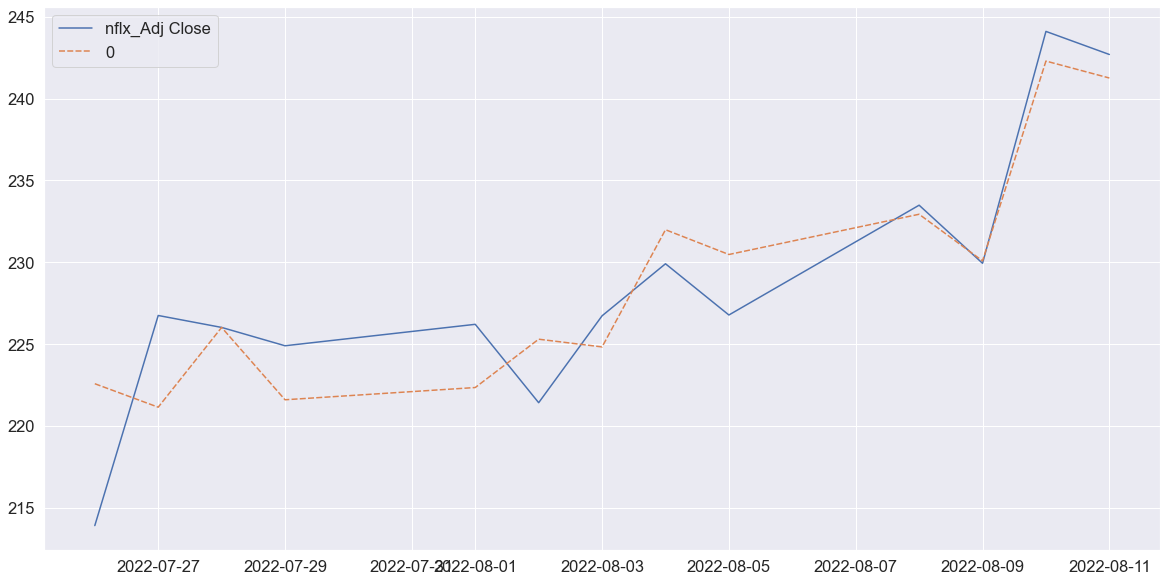

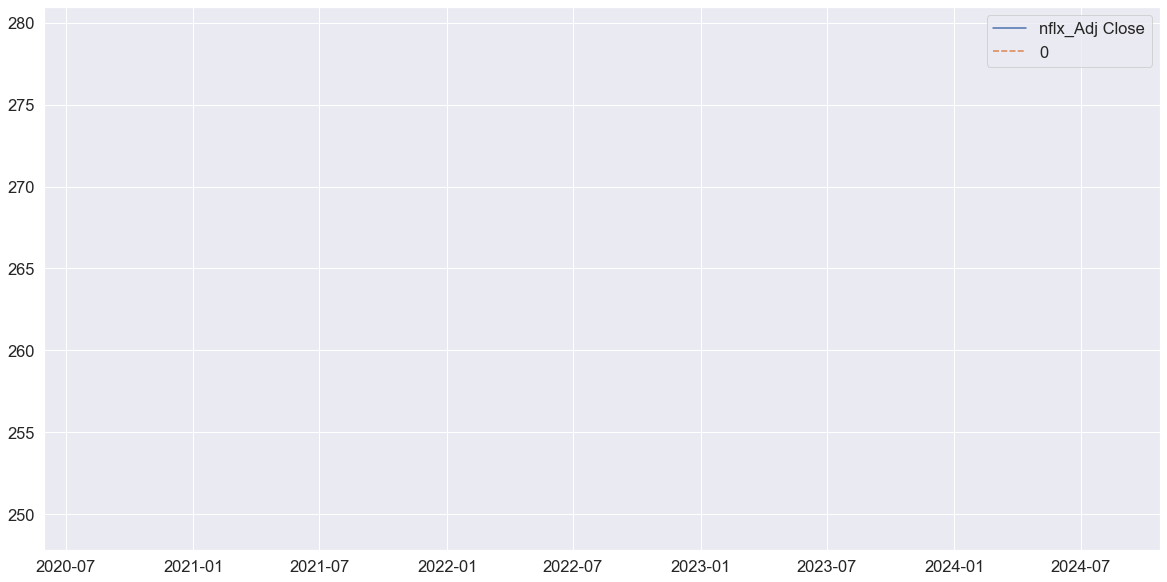

In [293]:
# plot training predictions
y_train_pred_df = pd.concat([y_train, pd.Series(y_train_pred, index=y_train.index)], axis=1)
sns.lineplot(data=y_train_pred_df)
plt.show()

# plot predictions
y_test_pred_df = pd.concat([y_test, pd.Series(y_test_pred, index=y_test.index)], axis=1)
sns.lineplot(data=y_test_pred_df)
plt.show()

In [294]:
y_train_pred_df

,nflx_Adj Close,0
2022-07-26,213.910004,222.579791
2022-07-27,226.750000,221.145009
2022-07-28,226.020004,226.020004
2022-07-29,224.899994,221.599025
2022-08-01,226.210007,222.347079
2022-08-02,221.419998,225.300370
2022-08-03,226.729996,224.828295
2022-08-04,229.910004,231.990193
2022-08-05,226.779999,230.476571
2022-08-08,233.490005,232.936214


# Optimization

In [295]:
# XGBoost params
xgb_params = {
    'regressor': [xgb.XGBRegressor()],
    # 'feature_engineering__num_transform_scaling': [MinMaxScaler(), StandardScaler()],
    'regressor__booster': ['gblinear'],
    'regressor__lambda': [0, 0.5, 1],
    'regressor__alpha': [0, 0.5 , 1],
}

In [296]:
# make custome scorer
rmse_score = metrics.make_scorer(functions.rmse, greater_is_better=False)

In [297]:
# instantiate gridsearch and time series CV technique
gridsearch = GridSearchCV(estimator=pipeline, param_grid=xgb_params, cv=TimeSeriesSplit(n_splits=3), scoring=rmse_score)

In [298]:
# find best model
gridsearch.fit(X_train, y_train)
best_model = gridsearch.best_estimator_
best_score = gridsearch.best_score_

c:\Users\lapen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\lapen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\lapen\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "c:\Users\lapen\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\lapen\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "c:\Users\lapen\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "c:\Users\lapen\anaconda3\li

In [299]:
# calculate optimized score
print('# train pred')
y_train_pred = best_model.predict(X_train)
functions.regression_results(y_train, y_train_pred)

print('# test pred')
y_test_pred = best_model.predict(X_test)
functions.regression_results(y_test, y_test_pred)

# train pred
explained_variance:  0.7279
mean_squared_log_error:  0.0003
r2:  0.7279
MAE:  3.153
MSE:  16.1214
RMSE:  4.0151
# test pred
explained_variance:  1.0
mean_squared_log_error:  0.0018
r2:  nan
MAE:  10.8965
MSE:  118.7344
RMSE:  10.8965


c:\Users\lapen\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


<AxesSubplot:>

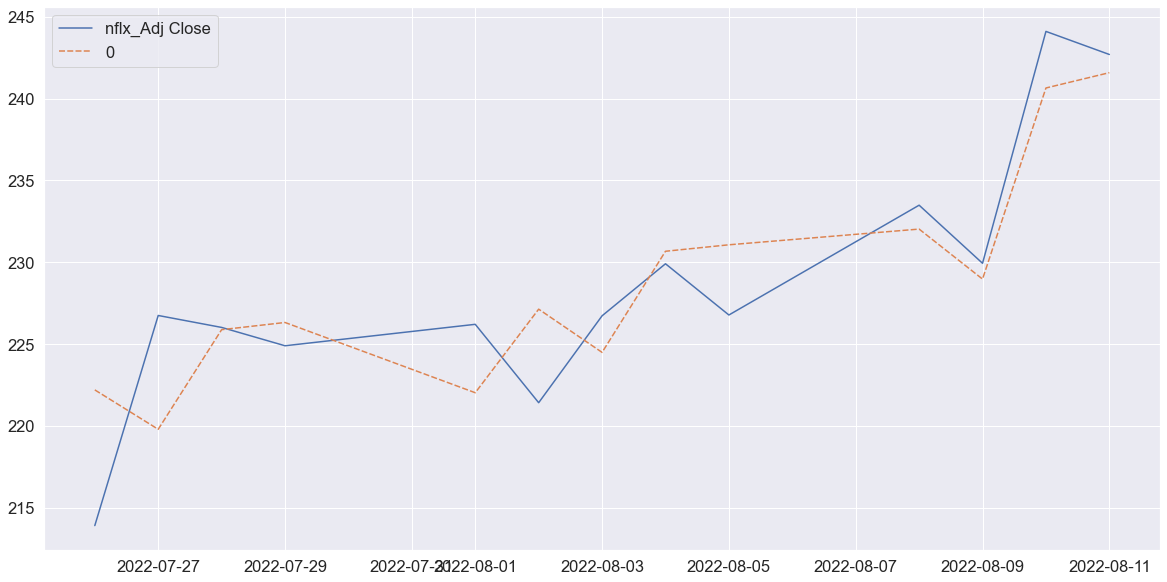

In [300]:
# plot training predictions
y_train_pred_df = pd.concat([y_train, pd.Series(y_train_pred, index=y_train.index)], axis=1)
sns.lineplot(data=y_train_pred_df)

<AxesSubplot:>

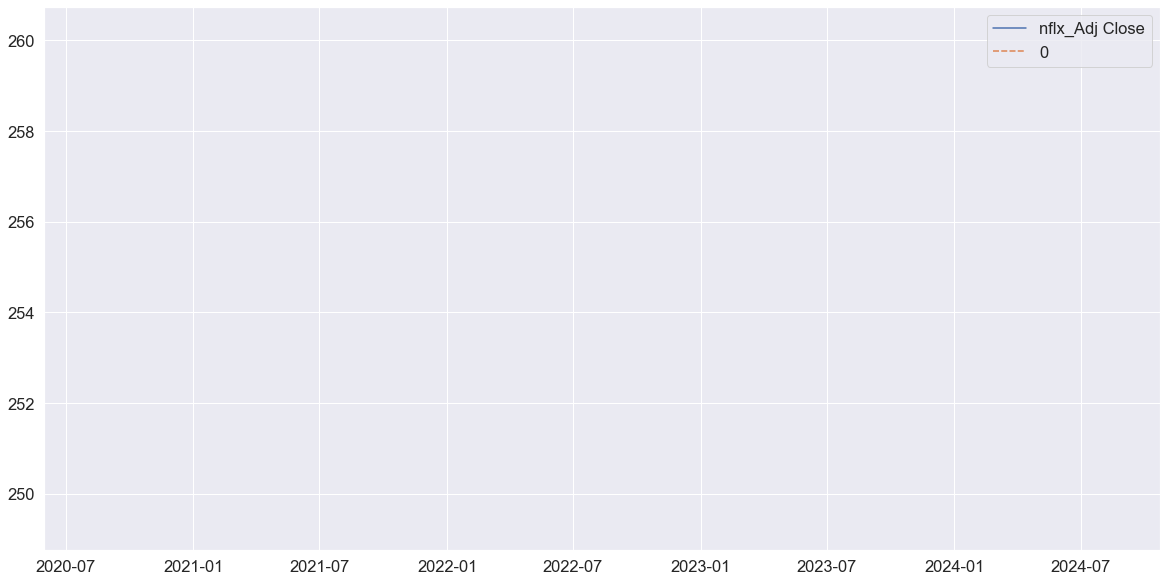

In [301]:
# plot predictions
y_test_pred_df = pd.concat([y_test, pd.Series(y_test_pred, index=y_test.index)], axis=1)
sns.lineplot(data=y_test_pred_df)